In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import copy
import random
from collections import defaultdict

import energyflow
from particle import Particle
import pennylane as qml
from tqdm import tqdm

import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch.nn import Linear, ReLU, Sigmoid, ModuleList, LeakyReLU, Linear, BatchNorm1d
from torch_geometric.nn import GATConv, global_mean_pool, global_max_pool
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.data import Data, Dataset
from torch.utils.data import Dataset
from torch_geometric.utils import to_networkx
from torch.optim import Adam
from torch_geometric.loader import DataLoader
from torch_geometric.utils import subgraph
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve

import wandb

In [2]:
os.chdir('..');
# print(os.getcwd())
from qssl.loss.losses import ContrastiveLoss
from qssl.training.trainer import run_model, train_model
from qssl.data.data_loader import preprocess_fixed_nodes, create_contrastive_graph_pairs
from qssl.data.data_preprocessing_augmentation import drop_nodes, drop_edges, mask_features, graph_augment
from qssl.utils.utils import visualize_graph_pairs, visualize_graph_pairs_01, plot_and_save_loss

In [3]:
n_connections = 6
input_dims = 8
hidden_dims = [64,32,32]
output_dims = 8
n_qubits = 5
q_depth = 1
epochs = 50
lr = 1e-3
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
batch_size = 1000

In [4]:
X = np.load(r'data/qg_graph/x10_sorted_12500.npy')
y = np.load(r'data/qg_graph/y10_sorted_12500.npy')
N=12500

In [5]:
x_data, y_data, edge_tensor, edge_indx_tensor, edge_attr_matrix, graph_help = preprocess_fixed_nodes(X,y, nodes_per_graph=8)

--- Finding All Unique Particles ---

--- Inserting Masses ---


14it [00:00, 895.22it/s]



--- Calculating Momenta and Energies ---

--- Calculating Edge Tensors ---


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:14<00:00, 879.93it/s]


In [6]:
train_index   = int(N*0.8)
val_index    = int(N*0.9)
dataset = []
for i in tqdm(range(N)):
    dataset.append(Data(edge_index=edge_indx_tensor[i,:,:],
                        x=x_data[i,:,:],
                        edge_attr=edge_attr_matrix[i,:],
                        y=y_data[i]))

original_dataset = dataset

100%|██████████████████████████████████████████████████████████████████████████| 12500/12500 [00:01<00:00, 9054.09it/s]


In [7]:
pairs, labels = create_contrastive_graph_pairs(dataset)

In [8]:
run = wandb.init(
    project = "ML4Sci-QuantumContrastiveLearning",
    config = {
        "dataset":"QG12500",
        "model":"QGNN",
        "loss":"contrastive pair loss"
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


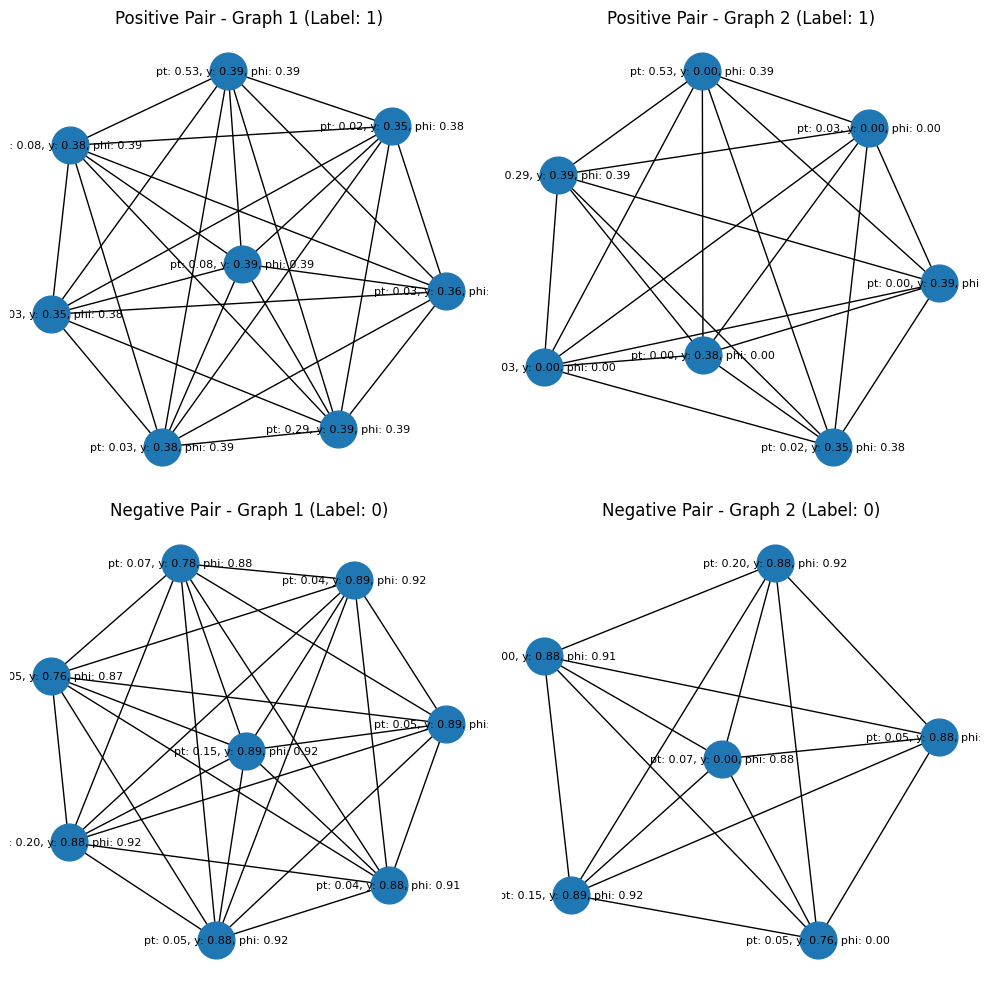

In [9]:
visualize_graph_pairs_01(pairs, labels)

In [10]:
class GraphPairDataset(Dataset):
    def __init__(self, pairs, labels):
        self.pairs = pairs  
        self.labels = labels 
        
    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        graph1, graph2 = self.pairs[idx]
        label = self.labels[idx]
        return graph1, graph2, label

In [11]:
def split_pairs(pairs, labels, train_ratio, val_ratio):
    train_pairs, temp_pairs, train_labels, temp_labels = train_test_split(
        pairs, labels, train_size=train_ratio, random_state=42, stratify=labels
    )
    val_pairs, test_pairs, val_labels, test_labels = train_test_split(
        temp_pairs, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
    )
    
    return train_pairs, train_labels, val_pairs, val_labels, test_pairs, test_labels

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_pairs, train_labels, val_pairs, val_labels, test_pairs, test_labels = split_pairs(
    pairs, labels, train_ratio, val_ratio
)

In [12]:
# Now, create datasets and dataloaders for each split
train_dataset = GraphPairDataset(train_pairs, train_labels)
val_dataset = GraphPairDataset(val_pairs, val_labels)
test_dataset = GraphPairDataset(test_pairs, test_labels)

batch_size = 1000

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [13]:
from qssl.models.qc import quantum_circuit_amplitude
from qssl.models.qgnn import HybridQuantumGNN

In [14]:
n_qubits = 6
data_size = 2**n_qubits

# Random normalized data for amplitude embedding
data = np.random.random(data_size)
data = data / np.linalg.norm(data)

# Random weights for parameterized RY rotations
weights = torch.randn(n_qubits, requires_grad=True)

# Run the quantum circuit
result = quantum_circuit_amplitude(data)
print(result)


[tensor(0.1216, dtype=torch.float64), tensor(0.0853, dtype=torch.float64), tensor(0.0145, dtype=torch.float64), tensor(0.0141, dtype=torch.float64), tensor(0.1914, dtype=torch.float64), tensor(-0.1133, dtype=torch.float64)]


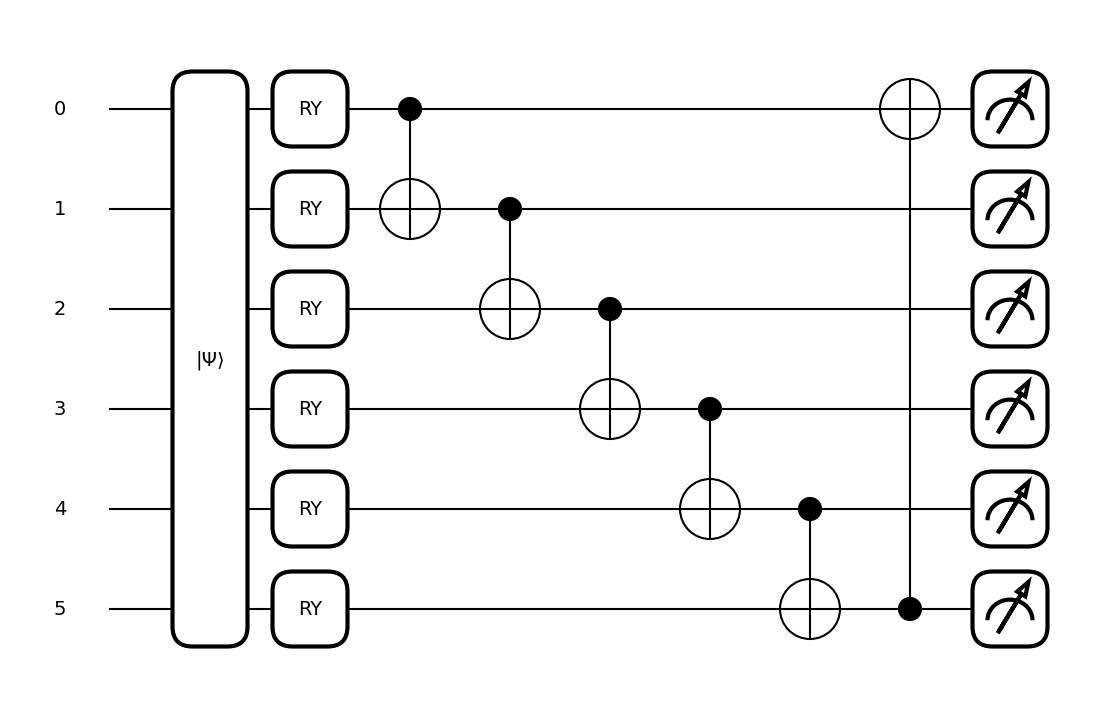

In [15]:
fig, ax = qml.draw_mpl(quantum_circuit_amplitude)(data)
wandb.log({"QGNN Quantum Circuit": wandb.Image(fig)})
plt.show()

In [16]:
class QuantumLayer(torch.nn.Module):
    def __init__(self):
        super(QuantumLayer, self).__init__()

    def forward(self, x):
        q_out = []
        for i in range(x.shape[0]):  # Apply quantum circuit on each input in the batch
            qc_output = quantum_circuit_amplitude(x[i])
            # Convert the list output to a tensor
            q_out.append(torch.tensor(qc_output, dtype=torch.float32))
        return torch.stack(q_out)

In [17]:
from qssl.training.trainer import run_qmodel, train_model

In [19]:
model = HybridQuantumGNN(input_dims,hidden_dims,output_dims,ReLU(),QuantumLayer(), n_qubits)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lossFn = ContrastiveLoss(margin=1.0)  # Use contrastive loss in pair mode
history = train_model(model, optimizer, lossFn=lossFn, epochs=50, lr=0.001, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

Epoch 1, Train Loss: 0.0087, Val Loss: 0.5573


KeyboardInterrupt: 

### LCT: Linear Classification Test

In [22]:
from qssl.evaluation.evaluate import run_model_lct

In [23]:
# After training, use the run_model function to extract embeddings from the validation/test dataset
train_embeddings, train_labels = run_model_lct(model, epoch=0, dataloader=train_dataloader, lossFn=lossFn, return_embeddings=True, train=False)
test_embeddings, test_labels = run_model_lct(model, epoch=0, dataloader=test_dataloader, lossFn=lossFn, return_embeddings=True, train=False)

# Convert embeddings and labels to numpy arrays for scikit-learn
X_train = train_embeddings.cpu().numpy()
y_train = train_labels.cpu().numpy()
X_test = test_embeddings.cpu().numpy()
y_test = test_labels.cpu().numpy()

Linear Classifier Test Accuracy: 57.01%
QGNN AUC Score: 0.5929


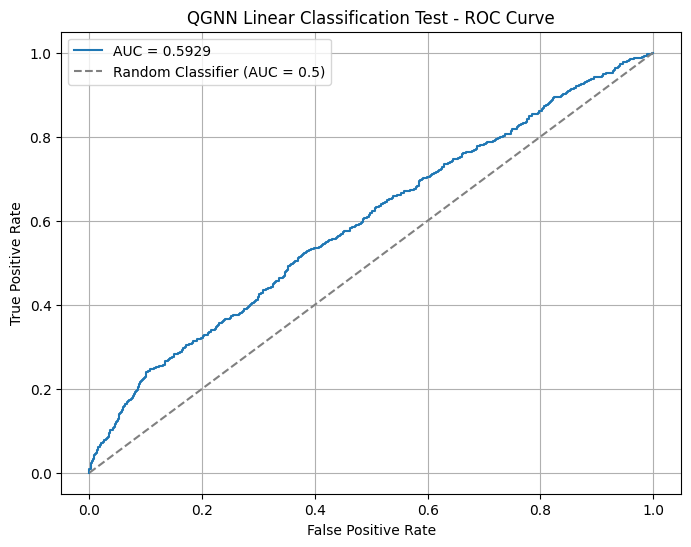

Confusion Matrix:
[[577 365]
 [441 492]]


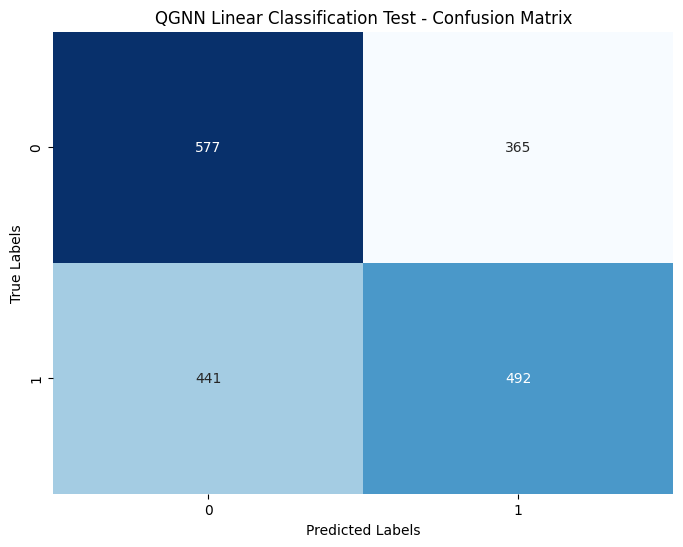

In [24]:
## Linear Classification Test
# Train a simple linear classifier (Logistic Regression)
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# Predict on test set
y_pred = classifier.predict(X_test)

# Compute accuracy of the linear classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Linear Classifier Test Accuracy: {accuracy * 100:.2f}%")
wandb.log({"QGNN Linear Classifier Test Accuracy": f"{accuracy * 100:.2f}%"})

# Compute the AUC score and plot the ROC curve
if len(np.unique(y_test)) == 2:  # Binary classification
    y_prob = classifier.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
    auc_score = roc_auc_score(y_test, y_prob)
    print(f"QGNN AUC Score: {auc_score:.4f}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    
    # Add the diagonal line representing random guessing
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier (AUC = 0.5)")
    
    # Label the plot
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("QGNN Linear Classification Test - ROC Curve")
    plt.legend()
    plt.grid(True)
    
    # Save and log the plot to WandB
    plt.savefig("roc_curve.png")
    wandb.log({"QGNN ROC Curve": wandb.Image("roc_curve.png")})
    
    # Show the plot (optional)
    plt.show()

# Compute and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('QGNN Linear Classification Test - Confusion Matrix')

# Save and log the confusion matrix plot to WandB
plt.savefig("confusion_matrix.png")
wandb.log({"QGNN Confusion Matrix": wandb.Image("confusion_matrix.png")})

plt.show()

In [25]:
wandb.finish()

qgnn epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
qgnn train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
qgnn val_loss,▁▁▃██▇▆▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂
QGNN Linear Classifier Test Accuracy,57.01%
qgnn epoch,50
qgnn train_loss,11.37401
qgnn val_loss,0.51341
